# Modeling

This notebook only cover the training of the U-Net and SegNet models.

### Data Loading

In [1]:
import os
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image

In [2]:
class TumorSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_files = sorted(self.image_dir.glob("*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = Path(self.mask_dir) / img_path.name

        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [3]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

In [4]:
dataset = TumorSegDataset("../data/converted/images", "../data/converted/masks", transform = transform)

### Data Splitting

In [5]:
from torch.utils.data import random_split

In [6]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

In [7]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 8, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 8, shuffle = False)

### Modeling

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
criterion = nn.BCELoss()

In [12]:
def dice_score(preds, targets, smooth = 1e-6):
    """
    Computes Dice Score (per batch).
    preds: tensor, shape (N, C, H, W) after applying sigmoid/softmax or thresholding
    targets: tensor, shape (N, C, H, W) one-hot encoded or same shape as preds
    """
    preds = preds.contiguous().view(preds.shape[0], -1)
    targets = targets.contiguous().view(targets.shape[0], -1)

    intersection = (preds * targets).sum(dim = 1)
    dice = (2. * intersection + smooth) / (preds.sum(dim = 1) + targets.sum(dim = 1) + smooth)
    return dice.mean().item()

In [13]:
def iou_score(preds, targets, smooth=1e-6):
    """
    Computes IoU (Jaccard Index) per batch.
    """
    preds = preds.contiguous().view(preds.shape[0], -1)
    targets = targets.contiguous().view(targets.shape[0], -1)

    intersection = (preds * targets).sum(dim=1)
    union = preds.sum(dim=1) + targets.sum(dim=1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

##### 1. U-Net

In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        m = self.middle(self.pool(e3))

        d3 = self.up3(m)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))

In [15]:
unet_model = UNet().to(device)
optimizer = optim.Adam(unet_model.parameters(), lr = 1e-4)

In [16]:
best_val_loss = float('inf')
patience = 10
trigger_times = 0

In [17]:
EPOCHS = 100

for epoch in range(EPOCHS):
    unet_model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = unet_model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    unet_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = unet_model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(unet_model.state_dict(), "../models/unet.pth")
    else:
        trigger_times += 1
        print(f"Early Stopping counter: {trigger_times} out of {patience}")
        if trigger_times >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1: Train Loss = 0.1210, Val Loss = 0.0656
Epoch 2: Train Loss = 0.0613, Val Loss = 0.0587
Epoch 3: Train Loss = 0.0584, Val Loss = 0.0565
Epoch 4: Train Loss = 0.0567, Val Loss = 0.0543
Epoch 5: Train Loss = 0.0536, Val Loss = 0.0507
Epoch 6: Train Loss = 0.0485, Val Loss = 0.0439
Epoch 7: Train Loss = 0.0434, Val Loss = 0.0394
Epoch 8: Train Loss = 0.0398, Val Loss = 0.0353
Epoch 9: Train Loss = 0.0362, Val Loss = 0.0353
Epoch 10: Train Loss = 0.0330, Val Loss = 0.0305
Epoch 11: Train Loss = 0.0305, Val Loss = 0.0328
Early Stopping counter: 1 out of 10
Epoch 12: Train Loss = 0.0284, Val Loss = 0.0304
Epoch 13: Train Loss = 0.0262, Val Loss = 0.0251
Epoch 14: Train Loss = 0.0237, Val Loss = 0.0248
Epoch 15: Train Loss = 0.0222, Val Loss = 0.0237
Epoch 16: Train Loss = 0.0203, Val Loss = 0.0236
Epoch 17: Train Loss = 0.0187, Val Loss = 0.0243
Early Stopping counter: 1 out of 10
Epoch 18: Train Loss = 0.0170, Val Loss = 0.0211
Epoch 19: Train Loss = 0.0147, Val Loss = 0.0226
Early 

In [43]:
unet_model.eval()
dice_total = 0
iou_total = 0
num_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = unet_model(images)

        if outputs.shape[1] == 1:  # Binary segmentation
            # probs = torch.sigmoid(outputs)
            probs = outputs
            preds = (probs > 0.5).float()
            targets = (masks > 0.5).float()
        else:  # Multiclass segmentation
            preds = torch.argmax(outputs, dim = 1)  # (N, H, W)
            targets = masks.long().squeeze(1)     # (N, H, W)

            # Convert preds and targets to one-hot for Dice and IoU
            preds = torch.nn.functional.one_hot(preds, num_classes=outputs.shape[1])  # (N,H,W,C)
            preds = preds.permute(0, 3, 1, 2).float()  # (N,C,H,W)
            targets = torch.nn.functional.one_hot(targets, num_classes=outputs.shape[1])
            targets = targets.permute(0, 3, 1, 2).float()

        dice = dice_score(preds, targets)
        iou = iou_score(preds, targets)

        dice_total += dice
        iou_total += iou
        num_batches += 1

print(f"Test Dice Score: {dice_total / num_batches:.4f}")
print(f"Test IoU Score: {iou_total / num_batches:.4f}")

Test Dice Score: 0.7035
Test IoU Score: 0.6223


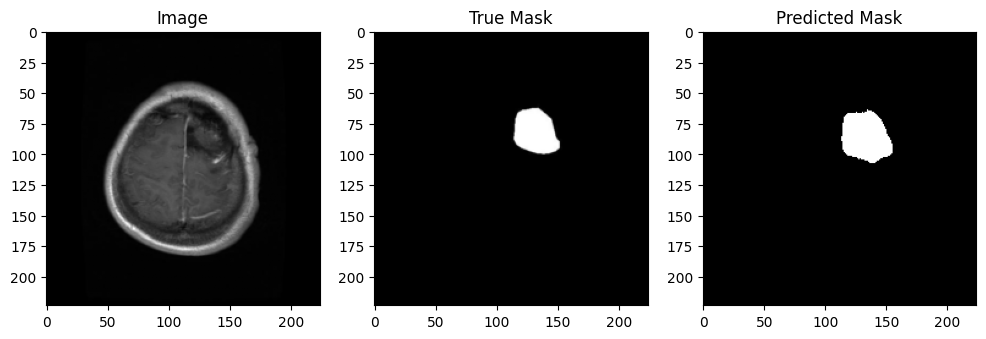

In [42]:
unet_model.eval()
with torch.no_grad():
    sample_img, sample_mask = test_dataset[1]
    pred = unet_model(sample_img.unsqueeze(0).to(device)).cpu().squeeze().numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.subplot(1,3,2)
    plt.title("True Mask")
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred > 0.5, cmap='gray')
    plt.show()

##### 2. SegNet

In [20]:
class SegNet(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super().__init__()

        def encoder_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.MaxPool2d(2, 2, return_indices = True)  # Save indices for unpooling
            )

        def decoder_block(in_c, out_c):
            return nn.Sequential(
                nn.MaxUnpool2d(2, 2),
                nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
                nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace = True),
            )

        self.enc1 = encoder_block(in_channels, 64)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)

        self.dec3 = decoder_block(256, 128)
        self.dec2 = decoder_block(128, 64)
        self.dec1 = nn.Sequential(
            nn.MaxUnpool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        e1, ind1 = self.enc1(x)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        d3 = self.dec3[0](e3, ind3)  # MaxUnpool2d with indices
        d3 = self.dec3[1:](d3)

        d2 = self.dec2[0](d3, ind2)
        d2 = self.dec2[1:](d2)

        d1 = self.dec1[0](d2, ind1)
        d1 = self.dec1[1:](d1)

        if self.dec1[-1].out_channels == 1:
            return torch.sigmoid(d1)
        else:
            return d1  # logits for multi-class

In [21]:
segnet_model = SegNet().to(device)
optimizer = optim.Adam(segnet_model.parameters(), lr = 1e-4)

In [22]:
best_val_loss = float('inf')
patience = 10
trigger_times = 0

In [23]:
EPOCHS = 100

for epoch in range(EPOCHS):
    segnet_model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = segnet_model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    segnet_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = segnet_model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(segnet_model.state_dict(), "../models/segnet.pth")
    else:
        trigger_times += 1
        print(f"Early Stopping counter: {trigger_times} out of {patience}")
        if trigger_times >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1: Train Loss = 0.1667, Val Loss = 0.0670
Epoch 2: Train Loss = 0.0520, Val Loss = 0.0425
Epoch 3: Train Loss = 0.0405, Val Loss = 0.0454
Early Stopping counter: 1 out of 10
Epoch 4: Train Loss = 0.0345, Val Loss = 0.0364
Epoch 5: Train Loss = 0.0309, Val Loss = 0.0287
Epoch 6: Train Loss = 0.0276, Val Loss = 0.0286
Epoch 7: Train Loss = 0.0255, Val Loss = 0.0260
Epoch 8: Train Loss = 0.0229, Val Loss = 0.0254
Epoch 9: Train Loss = 0.0207, Val Loss = 0.0265
Early Stopping counter: 1 out of 10
Epoch 10: Train Loss = 0.0188, Val Loss = 0.0274
Early Stopping counter: 2 out of 10
Epoch 11: Train Loss = 0.0166, Val Loss = 0.0264
Early Stopping counter: 3 out of 10
Epoch 12: Train Loss = 0.0150, Val Loss = 0.0246
Epoch 13: Train Loss = 0.0133, Val Loss = 0.0279
Early Stopping counter: 1 out of 10
Epoch 14: Train Loss = 0.0116, Val Loss = 0.0264
Early Stopping counter: 2 out of 10
Epoch 15: Train Loss = 0.0107, Val Loss = 0.0294
Early Stopping counter: 3 out of 10
Epoch 16: Train Loss =

In [44]:
segnet_model.eval()
dice_total = 0
iou_total = 0
num_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = segnet_model(images)

        if outputs.shape[1] == 1:  # Binary segmentation
            # probs = torch.sigmoid(outputs)
            probs = outputs
            preds = (probs > 0.5).float()
            targets = (masks > 0.5).float()
        else:  # Multiclass segmentation
            preds = torch.argmax(outputs, dim = 1)  # (N, H, W)
            targets = masks.long().squeeze(1)     # (N, H, W)

            # Convert preds and targets to one-hot for Dice and IoU
            preds = torch.nn.functional.one_hot(preds, num_classes=outputs.shape[1])  # (N,H,W,C)
            preds = preds.permute(0, 3, 1, 2).float()  # (N,C,H,W)
            targets = torch.nn.functional.one_hot(targets, num_classes=outputs.shape[1])
            targets = targets.permute(0, 3, 1, 2).float()

        dice = dice_score(preds, targets)
        iou = iou_score(preds, targets)

        dice_total += dice
        iou_total += iou
        num_batches += 1


print(f"Test Dice Score: {dice_total / num_batches:.4f}")
print(f"Test IoU Score: {iou_total / num_batches:.4f}")

Test Dice Score: 0.6880
Test IoU Score: 0.5918


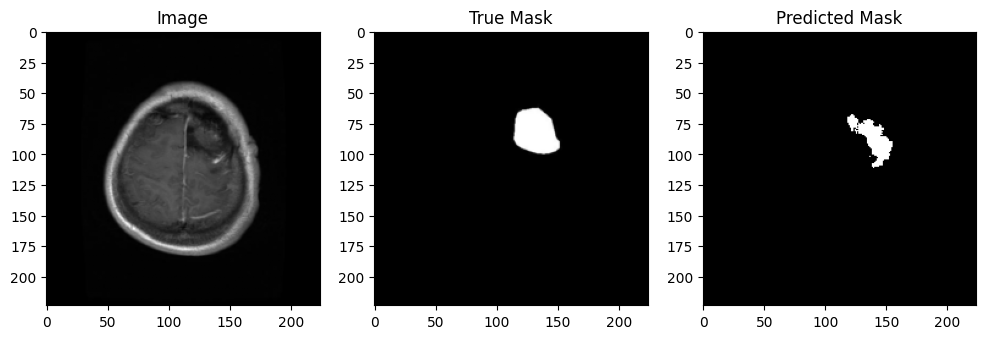

In [45]:
segnet_model.eval()
with torch.no_grad():
    sample_img, sample_mask = test_dataset[1]
    pred = segnet_model(sample_img.unsqueeze(0).to(device)).cpu().squeeze().numpy()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.title("Image")
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.subplot(1,3,2)
    plt.title("True Mask")
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.subplot(1,3,3)
    plt.title("Predicted Mask")
    plt.imshow(pred > 0.5, cmap='gray')
    plt.show()